## ---------------

In [1]:
import numpy as np
import itertools
import pygame
import random
import copy
import math
import matplotlib.pyplot as plt
from pygame.locals import *
import pygame_widgets
from pygame_widgets.slider import Slider
from pygame_widgets.textbox import TextBox

from pygame.locals import (
    K_UP,
    K_DOWN,
    K_LEFT,
    K_RIGHT,
    K_ESCAPE,
    KEYDOWN,
    QUIT,
)

pygame 2.5.2 (SDL 2.28.3, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Population:
    def __init__(self):
        self.pointType = 0
        self.staticField = 100000

    def getColour(self):
        if self.pointType == 0:
            return (139, 69, 19)  # Dirt
        elif self.pointType == 1:
            return (0, 255, 0)  # Grass
        elif self.pointType == 2:
            return (0, 0, 255)  # Blue
        elif self.pointType == 3:
            return (255, 0, 0)  # Red
        elif self.pointType == 4:
            return (0, 120, 0)  # Grass2

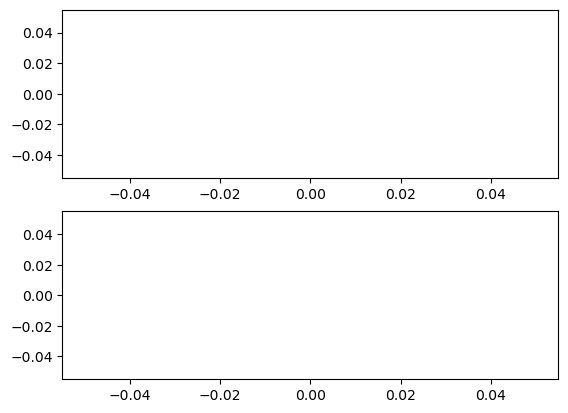

In [3]:
class Ground:
    def __init__(self, xSize=60, ySize=60):

        self.xSize = xSize
        self.ySize = ySize
        col = self.xSize
        row = self.ySize

        self.points = [[Population() for i in range(0, ySize)] for j in range(0, xSize)]
        self.S = 500
        self.population = Population()

    def calculate_grass(self, alpha_0, R, T0, Ea, I0, K0, L0, m1, y1, x1, a1, m2, y2, x2, a2, S0, D, t_values, dt, w):
        
        grass_values = []
        blue_agents = 0
        red_agents = 0
        grass_num = 0

        for x in range(self.xSize):
            for y in range(self.ySize):
                if self.points[x][y].pointType == 3:
                    blue_agents += 1

                elif self.points[x][y].pointType == 2:
                    red_agents += 1
                    
                elif self.points[x][y].pointType == 1:
                    grass_num += 1
                    
                elif self.points[x][y].pointType == 4:
                    grass_num += 2


        for i, t in enumerate(t_values):
            #K = K0 + 0.0000001 * t
            T = T0 + 0.1 * t
            #L = L0 - 0.05 * t
            K = -0.42
            L = 8.5

            alpha_t = alpha_0 * np.exp(-R * T / Ea)
            
            M = a * I0 * math.exp(-K * L)
            
            dS = (S0 + (M * math.sin(w * t))) * D - ((m1 / y1) * (x1 * self.S / (a1 + self.S))) - (
                        (m2 / y2) * (x2 * self.S / (a2 + self.S)))
            
            self.S = max(self.S + dS * dt, 0)
            grass_values.append(int(self.S))

            dx1 = (m1 * x1 * self.S / (a1 + grass_num)) - D1 * x1
            dx2 = (m2 * x2 * self.S / (a2 + grass_num)) - D2 * x2
            x1 += dx1 * dt 
            x2 += dx2 * dt

            diff1 = x1 - blue_agents
            diff2 = x2 - red_agents

            if (diff1) >= 1:
                self.add_species(3, int(diff1))

            elif (diff1) <= 0:
                self.remove_species(3, int(diff1))

            if (diff2) >= 1:
                self.add_species(2, int(diff2))

            elif (diff2) <= 0:
                self.remove_species(2, int(diff2))

            return (grass_values[-1], x1, x2)

    def createBoard(self, alpha_0, R, T0, Ea, I0, K0, L0, m1, y1, x1, a1, m2, y2, x2, a2, S0, D, t_values, dt, w):
        col = self.xSize
        row = self.ySize

        grass_count, x1, x2 = self.calculate_grass(alpha_0, R, T0, Ea, I0, K0, L0, m1, y1, x1, a1, m2, y2, x2, a2, S0, D,
                                                  t_values, dt, w)
        grass_count = min(grass_count, col * row)
        grass_indices = random.sample(range(col * row), grass_count)
        g = 0
        for x in range(col):
            for y in range(row):
                if g < grass_count and (x * row + y) in grass_indices:
                    self.points[x][y].pointType = 1
                    g += 1
                else:
                    self.points[x][y].pointType = 0
        self.init_species()

    def add_grass(self):
        
        enough_count = 0
        old_S = self.S
        self.calculate_grass(alpha_0, R, T0, Ea, I0, K0, L0, m1, y1, x1, a1, m2, y2, x2, a2, S0, D, t_values, dt, w)
        new_S = self.S

        if int(new_S) > int(old_S):
            difference = new_S - old_S
            for _ in range(int(difference)):
                # Find a cell with pointType 0 and change it to 1
                while True:
                    x = random.randint(0, self.xSize - 1)
                    y = random.randint(0, self.ySize - 1)
                    
                    enough_count += 1
                    
                    if self.points[x][y].pointType == 0:
                        self.points[x][y].pointType = 1
                        break
                    elif self.points[x][y].pointType == 1:
                        self.points[x][y].pointType = 4
                        break
                        
                    if enough_count == 100:
                        break
                        
        elif int(new_S) < int(old_S):
            difference = old_S - new_S
            for _ in range(int(difference)):
                # Find a cell with pointType 1 and change it to 0
                while True:
                    x = random.randint(0, self.xSize - 1)
                    y = random.randint(0, self.ySize - 1)
                    enough_count += 1
                    if self.points[x][y].pointType == 1:
                        self.points[x][y].pointType = 0
                        break

                    elif self.points[x][y].pointType == 4:
                        self.points[x][y].pointType = 1
                        break

                    if enough_count == 100:
                        break

    def init_species(self):
        self.add_species(2, 5)  # Red species
        self.add_species(3, 5)  # Blue species

    def add_species(self, species, count):
        enough_count = 0
        for _ in range(count):
            while True:
                x = random.randint(0, self.xSize-1)
                y = random.randint(0, self.ySize-1)
                enough_count += 1
                if self.points[x][y].pointType == 0:
                    self.points[x][y].pointType = species
                    #print("Species added: ", species)
                    break
                    
                elif enough_count == 100:
                    break

    def remove_species(self, species, count):
        enough_count = 0
        for _ in range(-count):
            while True:
                x = random.randint(0, self.xSize-1)
                y = random.randint(0, self.ySize-1)
                enough_count += 1
                if self.points[x][y].pointType == species:
                    self.points[x][y].pointType = 0
                    #print("Species removed: ", species)
                    break
                    
                elif enough_count == 100:
                    break

    def move_species(self, x1, x2):
        for x in range(self.xSize):
            for y in range(self.ySize):
                if self.points[x][y].pointType in [2, 3]:  # If the cell contains a species (red or blue)
                    

                    if random.random() < 0.7:  # 50% probability of moving
                        direction = random.randint(0, 4)
                        if direction == 0:
                            new_x, new_y = x + 0, y + 0
                        
                        elif direction == 1:
                            new_x, new_y = x + 1, y + 0
                            
                        elif direction == 2:
                            new_x, new_y = x + 0, y + 1
                            
                        elif direction == 3:
                            new_x, new_y = x - 1, y + 0
                            
                        elif direction == 4:
                            new_x, new_y = x + 0, y - 1

                        if 0 <= new_x < self.xSize and 0 <= new_y < self.ySize and (self.points[new_x][new_y].pointType == 0 or self.points[new_x][new_y].pointType == 1 or self.points[new_x][new_y].pointType == 4):
                            # Move to the new cell if it's within bounds and unoccupied
                            self.points[new_x][new_y].pointType = copy.deepcopy(self.points[x][y].pointType)
                            self.points[x][y].pointType = 0

    def drawGrid(self, screen, w_width, w_height, x1, x2):
        rows = len(self.points)
        cols = len(self.points[0])
        blockSize = (min(w_width, w_height) - max(rows, cols)) / max(rows, cols)

        for x in range(0, rows):
            for y in range(0, cols):
                pos_x = (blockSize + 1) * x
                pos_y = (blockSize + 1) * y
                rect = pygame.Rect(pos_x, pos_y, blockSize, blockSize)
                pygame.draw.rect(screen, self.points[x][y].getColour(), rect, 0)
        self.move_species(x1, x2)
        pygame.display.flip()

# Initialize matplotlib plots
fig, (ax_s, ax_x) = plt.subplots(2, 1)
line_s, = ax_s.plot([], label='S')
line_x1, = ax_x.plot([], label='x1', color='red')
line_x2, = ax_x.plot([], label='x2', color='blue')

# Function to update the plot for S
def update_plot_S(x, y):
    line_s.set_xdata(np.append(line_s.get_xdata(), x))
    line_s.set_ydata(np.append(line_s.get_ydata(), y))
    ax_s.relim()
    ax_s.autoscale_view()
    ax_s.legend()
    fig.canvas.draw()
    plt_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    plt_img = plt_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt_img = np.fliplr(plt_img)
    plt_img = np.rot90(plt_img, 1)
    plt_surf = pygame.surfarray.make_surface(plt_img)
    screen.blit(plt_surf, (660, 0))

# Function to update the plot for x1 and x2
def update_plot_pop(x, y1, y2):
    line_x1.set_xdata(np.append(line_x1.get_xdata(), x))
    line_x1.set_ydata(np.append(line_x1.get_ydata(), y1))
    line_x2.set_xdata(np.append(line_x2.get_xdata(), x))
    line_x2.set_ydata(np.append(line_x2.get_ydata(), y2))
    ax_x.relim()
    ax_x.autoscale_view()
    ax_x.legend()

In [ ]:
pygame.init()
# Parameters
w_width = 1300
w_height = 600
# Set up the drawing window, adjust the size
screen = pygame.display.set_mode([w_width, w_height])

# Create Board object
ground = Ground()

# Set background
screen.fill((255, 255, 255))

alpha_0 = 0.1  # Initial value of alpha
R = 8.314  # Gas constant
T0 = 300  # Initial temperature
Ea = 50  # Activation energy
D = 1  # Dilution rate
m1, m2 = 2.01, 1.65  # Maximum growth rates
y1, y2 = 2 * m1, 2 * m2 / 3  # Yield factors
a1, a2 = 5.45, 1  # Half-saturation constants
D1, D2 = 2.0, 1.62  # Death rates
b = 1.8  # Amplitude of the sinusoidal term
w = 0.2  # Angular frequency of the sinusoidal term
a = 4
L0 = 0.2
I0 = 1
K0 = 0.00000001
t = 10
S0 = 50
S = S0
x1 = 30
x2 = 30
dt = 0.1
t_max = 100000
x1_0, x2_0 = 10, 10  # Initial populations of species A and B
t_values = np.arange(0, t_max, dt)

ground.createBoard(alpha_0, R, T0, Ea, I0, K0, L0, m1, y1, x1, a1, m2, y2, x2, a2, S0, D, t_values, dt, w)

# Draw grid
ground.drawGrid(screen, w_width, w_height, x1, x2)

running = True

time_delay = 100  # 0.1 s
timer_event = pygame.USEREVENT + 1
pygame.time.set_timer(timer_event, time_delay)

while running:
    
    events = pygame.event.get()
    for event in events:
        if event.type == QUIT:
            running = False

        if event.type == KEYDOWN:
            if event.key == K_RIGHT:
                ground.add_grass()
                grass, x1, x2 = ground.calculate_grass(alpha_0, R, T0, Ea, I0, K0, L0, m1, y1, x1, a1, m2, y2, x2, a2,S0, D, t_values, dt, w)
                ground.drawGrid(screen, w_width, w_height, x1, x2)

        if event.type == timer_event:
            ground.add_grass()
            grass, x1, x2 = ground.calculate_grass(alpha_0, R, T0, Ea, I0, K0, L0, m1, y1, x1, a1, m2, y2, x2, a2,S0, D, t_values, dt, w)

            # Update the plot with the new value of S
            update_plot_S(len(line_s.get_xdata()), ground.S)

            # Update the plot with the new values of x1 and x2
            update_plot_pop(len(line_x1.get_xdata()), x1, x2)

            ground.drawGrid(screen, w_width, w_height, x1, x2)

            # Clear the previous text
            screen.fill((255, 255, 255), (600, 0, 75, 130))

            # Add text annotations for x1 and x2
            x1_text = f'x1: {x1:.0f}'
            x2_text = f'x2: {x2:.0f}'
            s_text = f'S: {ground.S:.0f}'
            
            pygame.font.init()
            font = pygame.font.Font(None, 24)
            text_x1 = font.render(x1_text, True, (255, 0, 0))
            text_x2 = font.render(x2_text, True, (0, 0, 255))
            text_s = font.render(s_text , True, (0, 120, 0))
            
            screen.blit(text_x1, (600, 10))
            screen.blit(text_x2, (600, 50))
            screen.blit(text_s, (600, 90))
            

    pygame.display.flip()

pygame.quit()

## -------